>[Data Reading Prepration](#scrollTo=04D_jHiClylt)

>[Data Reading Body](#scrollTo=AIUDAbfhqmIa)

>[CNN+LSTM Feeding FCEVAE](#scrollTo=E59XlnQaewiD)

>[FCEVAE Prepration](#scrollTo=gO-lPwB8Y1ZI)

>[FFT](#scrollTo=XRIGL9-bsYCb)

>[FCEVAE](#scrollTo=mDvdIFzs2zXZ)




# Data Reading Prepration

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LayerNormalization
from keras.regularizers import l2
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import glob
from dateutil.parser import parse
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#id
%cd gdrive/MyDrive/Sajjad_cloned_ready
!unzip 'Sajjad cloned_id.zip'

[Errno 2] No such file or directory: 'gdrive/MyDrive/Sajjad_cloned_ready'
/content/gdrive/MyDrive/Sajjad_cloned_ready
Archive:  Sajjad cloned_id.zip
replace 1 (12)/296707.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 1 (12)/296707.xlsx      
  inflating: 1 (12)/Fichiers text/296707, 01-03-2021,Uni, Ti-1, -.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 01-03-2021,Uni, Ti-2, $.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 01-09-2021,BiT,$.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 02-06-2021, BiF.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 05-03-2021,Uni, Tt, $.txt  
  inflating: 1 (12)/Fichiers text/296707, 08-03-2021,Uni, Tt, $.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 10-03-2021,Uni, Tt-1.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 10-03-2021,Uni, Tt-2.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 12-03-2021,BiF, Ti-1, -.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 12-03-2021,BiF, Ti-2, $.dat.txt  
  inflating: 1

In [ ]:
#2_channels
%cd gdrive/MyDrive/Sajjad_cloned_ready
!unzip 2_Channels.zip
%cd Données-Copie-Sept 2020_2_channel

[Errno 2] No such file or directory: 'gdrive/MyDrive/Sajjad_cloned_ready'
/content/gdrive/MyDrive/Sajjad_cloned_ready
Archive:  2_Channels.zip
replace Données-Copie-Sept 2020_2_channel/191007/191007,09-10-2019,BiT,$.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Données-Copie-Sept 2020_2_channel/191007/191007,09-10-2019,BiT,$.txt  
  inflating: Données-Copie-Sept 2020_2_channel/191007/191007.xlsx  
  inflating: Données-Copie-Sept 2020_2_channel/203961/203961.xlsx  
  inflating: Données-Copie-Sept 2020_2_channel/203961/Fichiers dat/203961, 04-08-2020,Uni,$.dat  
  inflating: Données-Copie-Sept 2020_2_channel/203961/Fichiers dat/203961, 13-07-2020,Uni.dat  
  inflating: Données-Copie-Sept 2020_2_channel/203961/Fichiers dat/203961, 20-07-2020, Uni.dat  
  inflating: Données-Copie-Sept 2020_2_channel/203961/Fichiers dat/203961, 24-07-2020, Uni,$.dat  
  inflating: Données-Copie-Sept 2020_2_channel/203961/Fichiers dat/203961, 27-07-2020, Uni$.dat  
  inflating: Données-Copie-Sept

# Data Reading Body

In [ ]:
#Extract the information of an EEG file from the excel file
def is_date(string, fuzzy=False):
   
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

def Date(List):
  for i in List:
    if is_date(i):
      return i
          
def get_patient_id(Str):

  for i in nltk.tokenize.wordpunct_tokenize(Str):
    if i.isdigit():
        if len(i)==6:
          return(i)
        elif len(i)>6:
          print('The Id number is incorrect for  file name:',Str) 
          print("Please make shure that the patient's id should be a six digits number")      

               
def EEG_reader(path):
  a = pd.read_fwf(path , skiprows=2, header=None, encoding='ISO-8859-1').drop(0, axis=0)
  b = pd.read_csv(path , skiprows=2, header=None, sep='\t', encoding='ISO-8859-1').drop(0, axis=0).drop(0, axis=1)
  if a.shape[1]>1:
    return a
  if b.shape[1]>1:
    return b
  if a.shape[1] + b.shape[1]<=2:
    raise Exception('The EEG file at {} has a shape or encoding error. make sure the encoding is Utf-8'.format(path))


In [ ]:
def cols(path):
  a = list(pd.read_fwf(path , header=None).drop(0, axis=0).iloc[1].values)
  if 'EEG0' in a or 'EEG1' in a or 'EEG2' in a or 'EEG3' in a:
    for i in a:
      if i.__class__ != str:
        a.remove(i)
    if a[-1].__class__ != str:
        a.remove(a[-1])     
    return a
  else:
    b= list(pd.read_csv(path,  header=None, sep='\t').drop(0, axis=0).drop(0, axis=1).iloc[0].values)
    if 'EEG0' in b or 'EEG1' in b or 'EEG2' in b or 'EEG3' in b:
      for i in b:
        if i.__class__ != str:
          b.remove(i)
      if b[-1].__class__ != str:
        b.remove(b[-1])      
      return b 
    else:
      raise ValueError('File in path: {} column is corrupted'.format(path)) 
# Writes the informention from excel file along with the EEG raw data into a dataframe.
# itretates over the whole EEG folders
n =30 # Number of EEG data folders
EEGs= []  # Will be the EEG stack
# cols = ['EEG1', 'EEG1', 'EEG2', 'EEG4', 'Site', 'Phase', 'Durée clinique ', 'Durée EEG', 'Qualité clinique',
#  'Adranergie', 'Qualité Aplatissement', 'Patho', 'Age', 'Sexe', 'Charge', 'Ti vs Tt', 'Anesthésiant', 'Qualité EEG']
# cols1 = ['EEG1', 'EEG1', 'Site', 'Phase', 'Durée clinique ', 'Durée EEG', 'Qualité clinique',
#  'Adranergie', 'Qualité Aplatissement', 'Patho', 'Age', 'Sexe', 'Charge', 'Ti vs Tt', 'Anesthésiant', 'Qualité EEG'] 

path_txt = glob.iglob('/content/gdrive/My Drive/Sajjad_cloned_ready/**/*.txt', recursive=True)
path_xls = glob.iglob('/content/gdrive/My Drive/Sajjad_cloned_ready/**/*.xlsx', recursive=True)
Path_xls = []
Path_txt = []
Txt = []
Xls = []
for i in path_txt:
  Path_txt.append(i)
for i in path_xls:
  Path_xls.append(i) 
for i in tqdm(Path_txt):
  Txt.append(EEG_reader(i))
for i in tqdm(Path_xls):
  Xls.append((i,pd.read_excel(i)))
  

duplicate = []
duplicate_names = None
for  i in range(len(Path_xls)):
  duplicate.append(Path_xls[i].split('/')[-1])
if len(duplicate)>=2:
  duplicate_names = True
else:
  duplicate_names = False

"___________________________________________________________________________________________"  
"___________________________________________________________________________________________"  
if duplicate_names == False:
  EEGs=[]
  c0=0
  c1=0
  for j in tqdm(Path_txt):
    for i in Xls: 
      try:
        Site = i[1] [i[1]['Date']==Date(j.split(',')).strip()]
      except:
        pass  
      if len(Site)>=1:
        EEG = Txt[Path_txt.index(j)]
        Site1 = Site.values
        try:
          for k in Site1:
            EEGs.append(pd.DataFrame(np.hstack([EEG.values, 
                                                np.vstack([k for i in range(EEG.shape[0])])]),columns=[*cols(j), *list(Site.columns)]))
            
        except:
          c1=Site 

"___________________________________________________________________________________________"  
"___________________________________________________________________________________________"   
if duplicate_names == True:
  print ("The Excel files' name  have duplicates")
  print(duplicate)

100%|██████████| 45/45 [00:01<00:00, 43.04it/s]

The Excel files' name  have duplicates
['135866.xlsx', '170894.xlsx', '191007.xlsx', '201575.xlsx', '203961.xlsx', '218132.xlsx', '218957.xlsx', '227193.xlsx', '234300.xlsx', '245446.xlsx', '258322.xlsx', '296707.xlsx', '325733.xlsx', '334217.xlsx', '348655.xlsx', '353456.xlsx', '354886.xlsx', '369690.xlsx', '377765.xlsx', '388304.xlsx', '465293.xlsx', '465293.xlsx', '494811.xlsx', '514538.xlsx', '525847.xlsx', '537723.xlsx', '640178.xlsx', '674119.xlsx', '685561.xlsx', '325733.xlsx', '354886.xlsx', '218132.xlsx', '369690.xlsx', '348655.xlsx', '234300.xlsx', '685561.xlsx', '465293.xlsx', '377765.xlsx', '526847.xlsx', '494811.xlsx', '465293.xlsx', '537723.xlsx', '191007.xlsx', '203961.xlsx', '353456.xlsx']


In [ ]:
EEGs_Quad_Channel=[]
EEGs_Dual_Channel=[]
Outlyers=[]
c0=0
c1=0
for j in tqdm(Path_txt):
  for i in Xls: 
    try:
      Site = i[1][i[1]['Date']==Date(j.split(',')).strip()]
    except:
      Site  
    if get_patient_id(j)==get_patient_id(i[0]):
      EEG = Txt[Path_txt.index(j)]
      Site1 = Site.values
      for k in Site1:
        mat = pd.DataFrame(np.hstack([EEG.values, np.vstack([k for i in range(EEG.shape[0])])]),columns=[*['EEG{}'.format(i) for i in range(EEG.shape[1])], *list(Site.columns)]).dropna(axis = 1, how = 'all')
        mat['Patient_id'] = get_patient_id(i[0])
        mat['Xls_file_path'] = i[0] 
        mat['EEG_file_path'] = j
        try:                                    
          Sexe = i[1]['Sexe'].iloc[0]
          Age = i[1]['Age'].iloc[0]
          Patho = i[1]['Patho'].iloc[0]
          mat['Sexe'].iloc[0] = Sexe
          mat['Age'].iloc[0] = Age
          mat['Patho'].iloc[0] = Patho
          
        except:
          pass 
          
        if 'EEG1'in list(mat.columns) and 'EEG2'in list(mat.columns) and 'EEG3'  in list(mat.columns):
          EEGs_Quad_Channel.append(mat)
        if 'EEG0' in list(mat.columns) and 'EEG1' in list(mat.columns) and 'EEG2' not in list(mat.columns):
          EEGs_Dual_Channel.append(mat)
        if 'EEG1' in list(mat.columns) and 'EEG2' in list(mat.columns) and 'EEG3' not in list(mat.columns):
          EEGs_Dual_Channel.append(mat)
        if 'EEG0'not in list(mat.columns) and 'EEG1'not in list(mat.columns) and 'EEG2' not in list(mat.columns):
          Outlyers.append(mat) 
        if 'ECG'in list(mat.columns):
          Outlyers.append(mat)    

         
        
     

 47%|████▋     | 197/420 [00:17<00:16, 13.20it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 77%|███████▋  | 323/420 [00:29<00:07, 12.67it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [ ]:
# i =25
# s= EEGs_Quad_Channel[i]['EEG1'].astype(float)[EEGs_Quad_Channel[i]['EEG1'].astype(float) ==EEGs_Quad_Channel[i]['EEG1'].astype(float).max()].index[0]
# t= EEGs_Quad_Channel[i]['EEG1'].astype(float)[EEGs_Quad_Channel[i]['EEG1'].astype(float) ==EEGs_Quad_Channel[i]['EEG1'].astype(float).min()].index[0]

# if s-300>0 and s+300<EEGs_Quad_Channel[i].shape[0] :
#   print(s, t)
#   EEGs_Quad_Channel[i]['EEG1'].astype(float)[s-300:s+300].plot(figsize=(15,10))
# else: 
#   print(s, t,EEGs_Quad_Channel[i]['EEG_file_path'][0])

In [ ]:
# Preshock and postshock seperation and concatenation

cols = ['index', 'EEG0', 'EEG1', 'EEG2', 'EEG3','Post_EEG0', 'Post_EEG1', 'Post_EEG2', 'Post_EEG3', 'Date', 'Ti vs Tt', 'Site',
       'Phase', '% Charge', 'Durée clinique ', 'Durée EEG', 'Anesthésiant',
       'Qualité clinique', 'Qualité EEG', 'Adranergie',
       'Qualité Aplatissement', 'Patient_id', 'Xls_file_path', 'EEG_file_path']
#=============================================================================================#
Pre_shock1 = [EEGs_Quad_Channel[i].iloc[0:min(EEGs_Quad_Channel[i]['EEG2'].astype(float)[EEGs_Quad_Channel[i]['EEG2'].astype(float) ==EEGs_Quad_Channel[i]['EEG2'].astype(float).max()].index[0],
                                              EEGs_Quad_Channel[i]['EEG0'].astype(float)[EEGs_Quad_Channel[i]['EEG0'].astype(float) ==EEGs_Quad_Channel[i]['EEG0'].astype(float).max()].index[0],
                                              EEGs_Quad_Channel[i]['EEG1'].astype(float)[EEGs_Quad_Channel[i]['EEG1'].astype(float) ==EEGs_Quad_Channel[i]['EEG1'].astype(float).max()].index[0],
                                              EEGs_Quad_Channel[i]['EEG3'].astype(float)[EEGs_Quad_Channel[i]['EEG3'].astype(float) ==EEGs_Quad_Channel[i]['EEG3'].astype(float).max()].index[0])].reset_index() for i in range(403)]
Post_shock1 = [EEGs_Quad_Channel[i].iloc[-1000:-1].reset_index() for i in range(403)]
#=============================================================================================#

for i in range(403):
  Pre_shock1[i]['Post_EEG0'] = Post_shock1[i]['EEG0'] 
  Pre_shock1[i]['Post_EEG1'] = Post_shock1[i]['EEG1'] 
  Pre_shock1[i]['Post_EEG2'] = Post_shock1[i]['EEG2'] 
  Pre_shock1[i]['Post_EEG3'] = Post_shock1[i]['EEG3'] 
  Pre_shock1[i] = Pre_shock1[i].reindex(columns = cols)
  

In [ ]:
Pre_post_shock = pd.concat(Pre_shock1, axis=0)

Quad channel success rate

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  fig.canvas.print_figure(bytes_io, **kw)


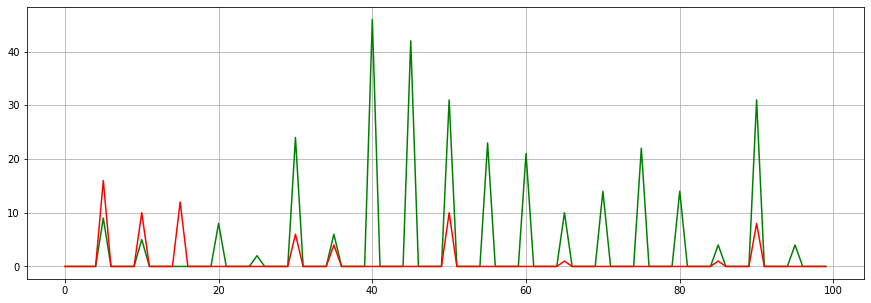

In [ ]:
G =[]
B =[]

for j in range (100):
  g = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité EEG'].iloc[0]=='+']
  g1 = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité EEG'].iloc[0]=='++']
  g2 = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité EEG'].iloc[0]=='+++']

  b = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité EEG'].iloc[0]=='-']
  G.append(len(g)+len(g1)+len(g2))
  B.append(len(b))
plt.figure(figsize=(15,5))
plt.plot(G, color ='G')
plt.plot(B, color ='R')  
plt.grid()
plt.show()

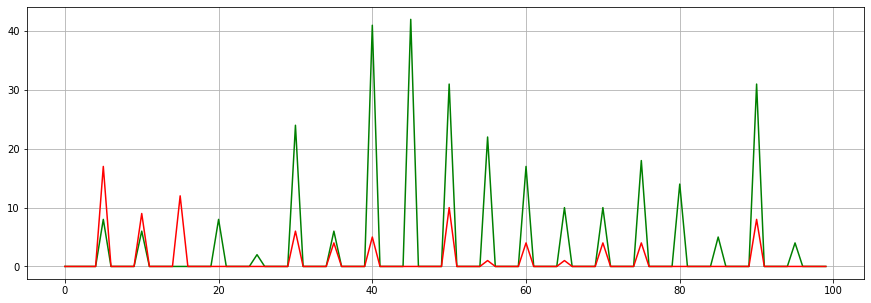

In [ ]:
G =[]
B =[]

for j in range (100):
  g = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité clinique'].iloc[0]=='+']
  g1 = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité clinique'].iloc[0]=='++']
  g2 = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité clinique'].iloc[0]=='+++']

  b = [Pre_shock1[i] for i in range(403) if Pre_shock1[i]['% Charge'].iloc[0]==j and Pre_shock1[i]['Qualité clinique'].iloc[0]=='-']
  G.append(len(g)+len(g1)+len(g2))
  B.append(len(b))
plt.figure(figsize=(15,5))
plt.plot(G, color ='G')
plt.plot(B, color ='R')  
plt.grid()
plt.show()

In [ ]:
Good_titration=[]
Bad_titration=[]

for i in Pre_shock1:
  if i['% Charge'].iloc[0]==5 and i['Qualité EEG'].iloc[0]=='+++':
    Good_titration.append(i)
  if i['% Charge'].iloc[0]==5 and i['Qualité EEG'].iloc[0]=='-':
    Bad_titration.append(i)  

print(len(Bad_titration),len(Good_titration))    

16 3


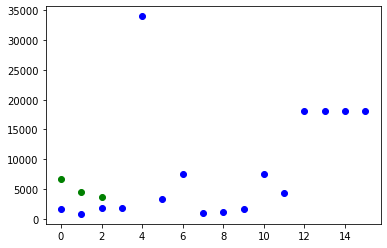

In [ ]:
temp1g=[]
temp1b=[]
for i in range(len(Good_titration)):
   y = Good_titration[i]['EEG0'].values.astype(float)
   yf = scipy.fftpack.fft(y)
   temp1g.append(np.abs(yf)[13])
for j in range(len(Bad_titration)):
  y1 = Bad_titration[j]['EEG0'].values.astype(float)
  y1f = scipy.fftpack.fft(y1)
  temp1b.append(np.abs(y1f)[10])

plt.plot(temp1g, 'go' )  
plt.plot(temp1b, 'bo')
plt.show()

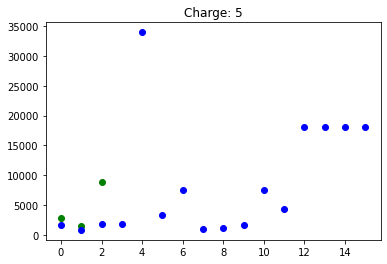

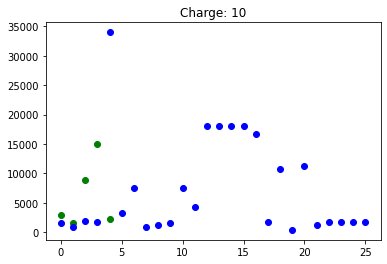

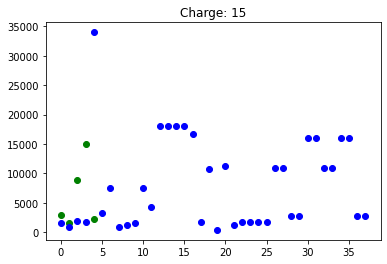

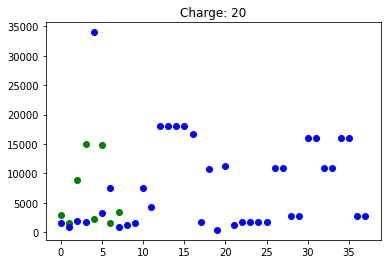

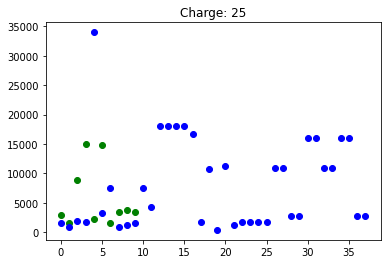

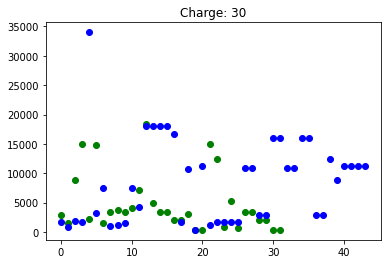

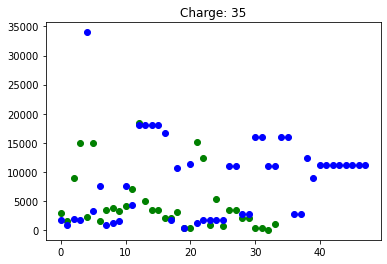

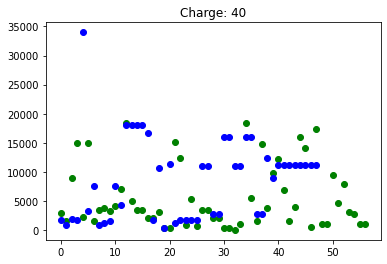

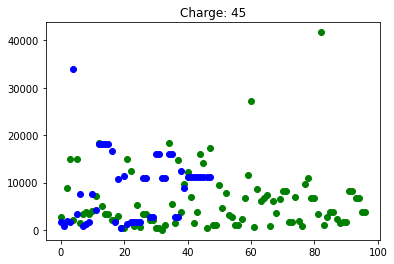

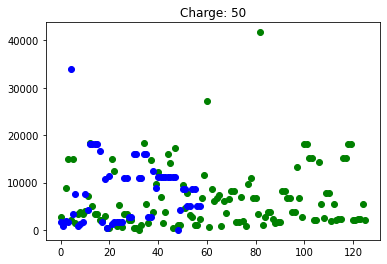

IndexError: ignored

In [ ]:
Good_titration=[]
Bad_titration=[]
for c in [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]:
  for i in Pre_shock1:
    if i['% Charge'].iloc[0]==c and i['Qualité EEG'].iloc[0]=='+++':
      Good_titration.append(i)
    if i['% Charge'].iloc[0]==c and i['Qualité EEG'].iloc[0]=='-':
      Bad_titration.append(i)  
    
  temp1g=[]
  temp1b=[]
  if len(Good_titration)>0:
    for i in range(len(Good_titration)):
      y = Good_titration[i]['EEG0'].values.astype(float)
      yf = scipy.fftpack.fft(y)
      temp1g.append(np.abs(yf)[10])
  else:
    pass    
  if len(Bad_titration)>0:  
    for j in range(len(Bad_titration)):
      y1 = Bad_titration[j]['EEG0'].values.astype(float)
      y1f = scipy.fftpack.fft(y1)
      temp1b.append(np.abs(y1f)[10])
  else:
    pass    

  plt.plot(temp1g, 'go' )  
  plt.plot(temp1b, 'bo')
  plt.title('Charge: {}'.format(c))
  plt.show()  

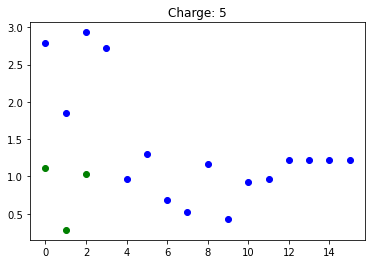

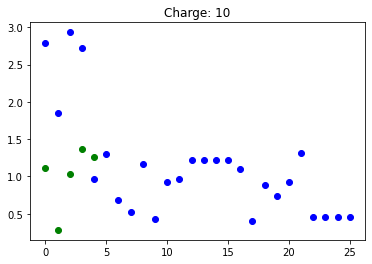

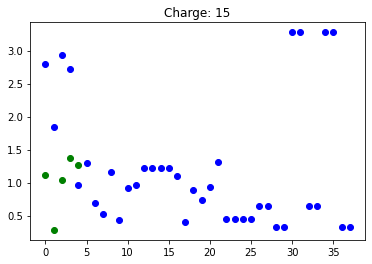

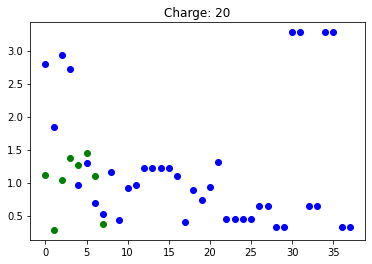

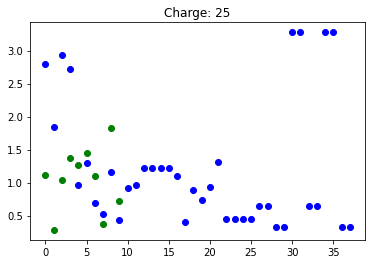

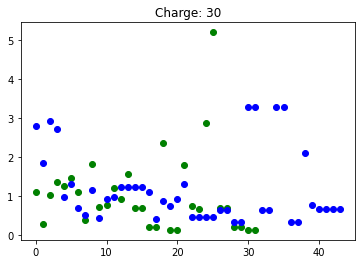

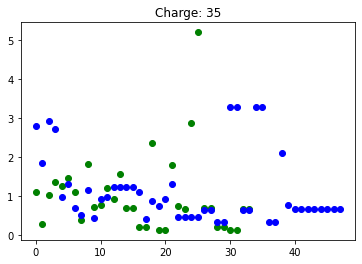

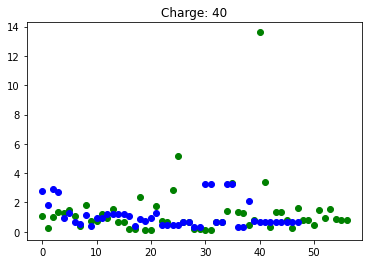

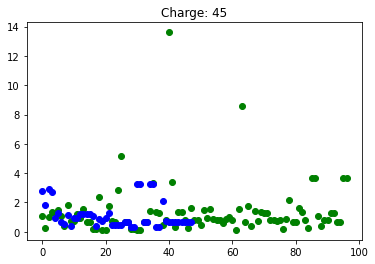

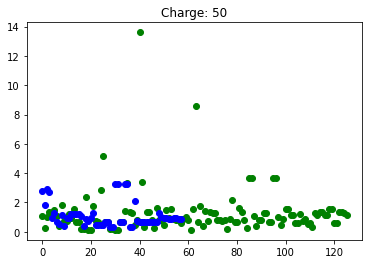

IndexError: ignored

In [ ]:
Good_titration=[]
Bad_titration=[]
for c in [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]:
  for i in Pre_shock1:
    if i['% Charge'].iloc[0]==c and i['Qualité EEG'].iloc[0]=='+++':
      Good_titration.append(i)
    if i['% Charge'].iloc[0]==c and i['Qualité EEG'].iloc[0]=='-':
      Bad_titration.append(i)  
    
  temp1g=[]
  temp1b=[]
  if len(Good_titration)>0:
    for i in range(len(Good_titration)):
      y = Good_titration[i]['EEG0'].values.astype(float)
      yf = scipy.fftpack.fft(y)
      temp1g.append(np.abs(yf)[10]/np.abs(yf)[12])
  else:
    pass    
  if len(Bad_titration)>0:  
    for j in range(len(Bad_titration)):
      y1 = Bad_titration[j]['EEG0'].values.astype(float)
      y1f = scipy.fftpack.fft(y1)
      temp1b.append(np.abs(y1f)[10]/np.abs(y1f)[12])
  else:
    pass    

  plt.plot(temp1g, 'go' )  
  plt.plot(temp1b, 'bo')
  plt.title('Charge: {}'.format(c))
  plt.show()  

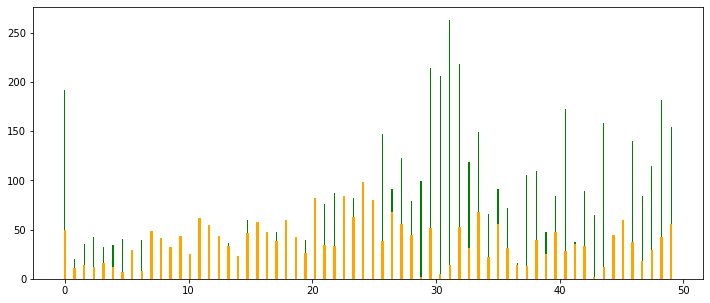

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
n=4
# Number of sample points
N = 128
# sample spacing
T = 1.0 / 100
x = np.linspace(0.0, N*T, N)
y = Good_titration[n]['EEG2'].values.astype(float)
y1 = Bad_titration[n]['EEG2'].values.astype(float)
yf = scipy.fftpack.fft(y)
y1f = scipy.fftpack.fft(y1)
xf = np.linspace(0.0, 1.0//(2.0*T), N//2)

fig, ax = plt.subplots(figsize = (12,5))
ax.bar(xf, 2.0/N * np.abs(yf[:N//2]),width=0.1, color ='g')
ax.bar(xf, 2.0/N * np.abs(y1f[:N//2]),width=0.2 ,color ='orange')
plt.show()

2022-05-31

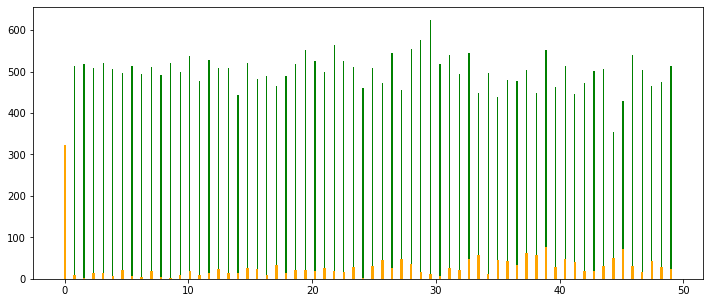

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
n=2
m=4
# Number of sample points
N = 128
# sample spacing
T = 1.0 / 100
x = np.linspace(0.0, N*T, N)
y = Good_titration[n]['EEG2'].values.astype(float)
y1 = Bad_titration[m]['EEG2'].values.astype(float)
yf = scipy.fftpack.fft(y)
y1f = scipy.fftpack.fft(y1)
xf = np.linspace(0.0, 1.0//(2.0*T), N//2)

fig, ax = plt.subplots(figsize = (12,5))
ax.bar(xf, 2.0/N * np.abs(yf[:N//2]),width=0.1, color ='g')
ax.bar(xf, 2.0/N * np.abs(y1f[:N//2]),width=0.2 ,color ='orange')
plt.show()

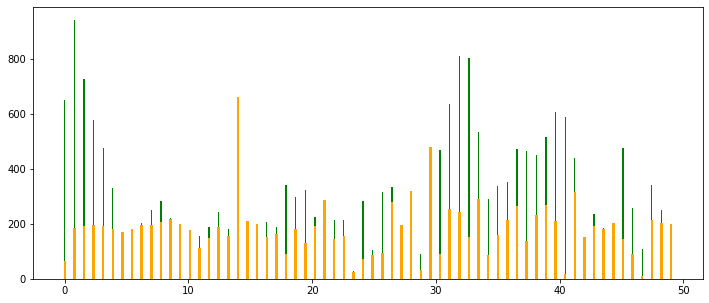

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
n=7
# Number of sample points
N = 128
# sample spacing
T = 1.0 / 100
x = np.linspace(0.0, N*T, N)
y = Good_titration[n]['EEG0'].values.astype(float)
y1 = Good_titration[0]['EEG0'].values.astype(float)
yf = scipy.fftpack.fft(y)
y1f = scipy.fftpack.fft(y1)
xf = np.linspace(0.0, 1.0//(2.0*T), N//2)

fig, ax = plt.subplots(figsize = (12,5))
ax.bar(xf, 2.0/N * np.abs(yf[:N//2]),width=0.1, color ='g')
ax.bar(xf, 2.0/N * np.abs(y1f[:N//2]),width=0.2 ,color ='orange')
plt.show()

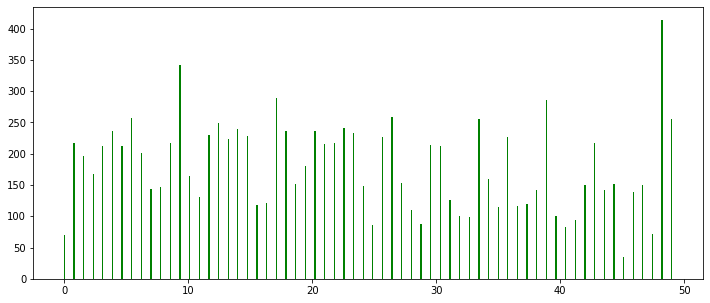

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
n=1
# Number of sample points
N = 128
# sample spacing
T = 1.0 / 100
x = np.linspace(0.0, N*T, N)
y = Good_titration[n]['EEG1'].values.astype(float)
# y1 = Good_titration[0]['EEG1'].values.astype(float)
yf = scipy.fftpack.fft(y)
# y1f = scipy.fftpack.fft(y1)
xf = np.linspace(0.0, 1.0//(2.0*T), N//2)

fig, ax = plt.subplots(figsize = (12,5))
ax.bar(xf, 2.0/N * np.abs(yf[:N//2]),width=0.1, color ='g')
# ax.bar(xf, 2.0/N * np.abs(y1f[:N//2]),width=0.2 ,color ='orange')
plt.show()

In [ ]:
# for n in range(9):
#   y = Bad_titration[n]['EEG1'].values.astype(float)
#   yf = scipy.fftpack.fft(y)
#   print(np.abs(yf[:N//2])[15]/64 )


Dual channel success rate

In [ ]:
# Preshock and postshock seperation and concatenation Dual channel

cols = ['index', 'EEG0', 'EEG1','Post_EEG0', 'Post_EEG1', 'Date', 'Ti vs Tt', 'Site',
       'Phase', '% Charge', 'Durée clinique ', 'Durée EEG', 'Anesthésiant',
       'Qualité clinique', 'Qualité EEG', 'Adranergie',
       'Qualité Aplatissement', 'Patient_id', 'Xls_file_path', 'EEG_file_path']
#=============================================================================================#
Pre_shock2 = [EEGs_Dual_Channel[i].iloc[0:min(EEGs_Dual_Channel[i]['EEG0'].astype(float)[EEGs_Dual_Channel[i]['EEG0'].astype(float) ==EEGs_Dual_Channel[i]['EEG0'].astype(float).max()].index[0],
                                              EEGs_Dual_Channel[i]['EEG1'].astype(float)[EEGs_Dual_Channel[i]['EEG1'].astype(float) ==EEGs_Dual_Channel[i]['EEG1'].astype(float).max()].index[0])].reset_index() for i in range(194)]
Post_shock2 = [EEGs_Dual_Channel[i].iloc[-1000:-1].reset_index() for i in range(194)]
#=============================================================================================#

for i in range(194):
  Pre_shock2[i]['Post_EEG0'] = Post_shock2[i]['EEG0'] 
  Pre_shock2[i]['Post_EEG1'] = Post_shock2[i]['EEG1'] 
  Pre_shock2[i] = Pre_shock2[i].reindex(columns = cols)
  

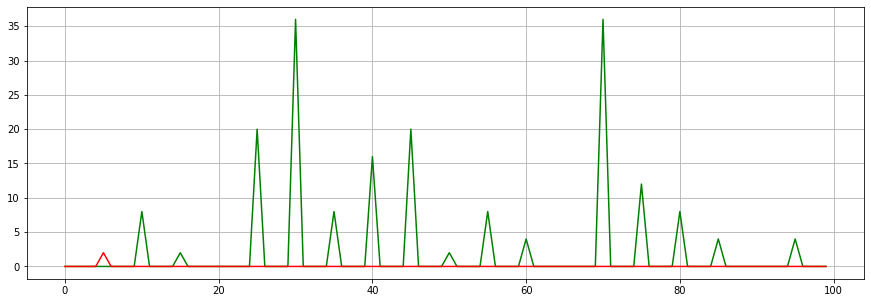

In [ ]:
G =[]
B =[]

for j in range (100):
  g = [Pre_shock2[i] for i in range(194) if Pre_shock2[i]['% Charge'].iloc[0]==j and Pre_shock2[i]['Qualité EEG'].iloc[0]=='+']
  g1 = [Pre_shock2[i] for i in range(194) if Pre_shock2[i]['% Charge'].iloc[0]==j and Pre_shock2[i]['Qualité EEG'].iloc[0]=='++']
  g2 = [Pre_shock2[i] for i in range(194) if Pre_shock2[i]['% Charge'].iloc[0]==j and Pre_shock2[i]['Qualité EEG'].iloc[0]=='+++']

  b = [Pre_shock2[i] for i in range(194) if Pre_shock2[i]['% Charge'].iloc[0]==j and Pre_shock2[i]['Qualité EEG'].iloc[0]=='-']
  G.append(len(g)+len(g1)+len(g2))
  B.append(len(b))
plt.figure(figsize=(15,5))
plt.plot(G, color ='G')
plt.plot(B, color ='R')  
plt.grid()
plt.show()

In [ ]:
Pre_post_shock2 = pd.concat(Pre_shock2, axis=0)

EEGs Concatenation

In [ ]:
Concat_quad0= pd.concat([EEGs_Quad_Channel[i] for i in range(200)], axis=0)[['EEG0','EEG1','EEG2','EEG3','% Charge','Qualité clinique']]
pd.to_pickle(Concat_quad0, 'Concat_quad0.pkl')
del Concat_quad0

In [ ]:
Concat_quad1= pd.concat([EEGs_Quad_Channel[i] for i in range(200,403)], axis=0)[['EEG0','EEG1','EEG2','EEG3','% Charge','Qualité clinique']]
pd.to_pickle(Concat_quad1, 'Concat_quad1.pkl')
del Concat_quad1

In [ ]:
Concat_quad= pd.concat([pd.read_pickle('Concat_quad0.pkl'), pd.read_pickle('Concat_quad1.pkl')], axis=0)

In [ ]:
pd.to_pickle(Concat_quad, 'Concat_quad.pkl')

In [ ]:
%cd /content/gdrive/MyDrive/Sajjad_cloned_ready

/content/gdrive/MyDrive/Sajjad_cloned_ready


In [ ]:
!cp Concat_quad.pkl /content/gdrive/MyDrive/Sajjad_cloned_ready/Concat_quad.pkl

In [ ]:
Concat_quad_pkl = pd.read_pickle('Concat_quad.pkl')

Scaling

In [ ]:
# In the charge column some of the rows' value is: '5 puis 10' which is not a float so we repalced it by the 10.
Concat_quad_pkl = Concat_quad_pkl.replace('5 puis 10',10)

In [ ]:
scale = MinMaxScaler()
Concat_quad_pkl[['EEG0','EEG1','EEG2','EEG3','% Charge']] = scale.fit_transform(Concat_quad_pkl[['EEG0','EEG1','EEG2','EEG3','% Charge']])

In [ ]:
#Saving data to gdrive
pd.to_pickle(Concat_quad_pkl, 'Concat_quad_pkl_scaled.pkl')
!cp 'Concat_quad_pkl_scaled.pkl' /content/gdrive/MyDrive/Sajjad_cloned_ready/Concat_quad_scaled.pkl

In [ ]:
Concat_quad_pkl = pd.read_pickle('/content/gdrive/MyDrive/Sajjad_cloned_ready/Concat_quad_scaled.pkl')

Label encoding

Dataset and label prepration

In [ ]:
Concat_quad_pkl = Concat_quad_pkl.dropna()

In [ ]:
# Choosing only the good EEGs
Dataset = Concat_quad_pkl[(Concat_quad_pkl['Qualité clinique']== '+++') | (Concat_quad_pkl['Qualité clinique']== '++')][['EEG0','EEG1','EEG2','EEG3','% Charge']]

In [ ]:
# We defined a function to make a dataset with demanded element size

def elementor(df, element_size):
  t0 = df[list(df.columns)[0:-1]].values
  round = int(t0.shape[0]/element_size)
  t0 = t0[0:(round*element_size)]
  return t0.reshape((round, element_size, df.shape[1]-1)), np.array([df[list(df.columns)[-1]].iloc[i*element_size:(i+1)*element_size].mean()  for i in range(round)])

data, label = elementor(Dataset,196)

In [ ]:
print('data shape: ',data.shape,'\t' ,'label shape: ',label.shape )

data shape:  (49473, 196, 4) 	 label shape:  (49473,)


In [ ]:
print(np.any(np.isnan(data)))

False


In [ ]:
TrainsetF,TestsetF, LabelFairl, TestLabelFairl=train_test_split(data ,label,test_size=0.33)

#CNN+LSTM Feeding FCEVAE

In [ ]:
# TrainsetF,TestsetF, LabelFairl, TestLabelFairl=train_test_split(Pre_post_shock.reshape((3765624, 4, 1)),Pre_post_shock.reshape((3765624, 4, 1))['%Charge'] ,test_size=0.33)

In [ ]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import TimeDistributed

model = Sequential()
model.add(Conv1D(32,3,input_shape=(TrainsetF.shape[1], TrainsetF.shape[2])))

model.add(Dropout(0.2))
model.add(LSTM(256,activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='tanh'))
model.compile(optimizer='adam', loss='binary_crossentropy')

# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=2, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

model.fit(TrainsetF, LabelFairl, epochs=50, batch_size=2048,shuffle=True, verbose=1,validation_data=(TestsetF, TestLabelFairl))


Epoch 1/50
17/17 [==============================] - 11s 556ms/step - loss: 0.7426 - val_loss: 0.6992
Epoch 2/50
17/17 [==============================] - 10s 591ms/step - loss: 0.6958 - val_loss: 0.6950
Epoch 3/50
17/17 [==============================] - 9s 530ms/step - loss: 0.6946 - val_loss: 0.6934
Epoch 4/50
17/17 [==============================] - 9s 535ms/step - loss: 0.6943 - val_loss: 0.6933
Epoch 5/50
17/17 [==============================] - 11s 667ms/step - loss: 0.6942 - val_loss: 0.6933
Epoch 6/50
17/17 [==============================] - 9s 531ms/step - loss: 0.6941 - val_loss: 0.6932
Epoch 7/50
17/17 [==============================] - 9s 528ms/step - loss: 0.6941 - val_loss: 0.6934
Epoch 8/50
17/17 [==============================] - 9s 530ms/step - loss: 0.6938 - val_loss: 0.6932
Epoch 9/50
17/17 [==============================] - 9s 525ms/step - loss: 0.6937 - val_loss: 0.6931
Epoch 10/50
17/17 [==============================] - 9s 534ms/step - loss: 0.6938 - val_loss: 0.6

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 194, 32)           416       
                                                                 
 dropout_9 (Dropout)         (None, 194, 32)           0         
                                                                 
 lstm_13 (LSTM)              (None, 256)               295936    
                                                                 
 dense_27 (Dense)            (None, 20)                5140      
                                                                 
 dense_28 (Dense)            (None, 10)                210       
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 301,713
Trainable params: 301,713
Non-tr

In [ ]:
from keras.models import Model
layer_name = 'dense_27'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(data)

In [ ]:
numpy.savetxt("intermediate_output.csv", intermediate_output, delimiter=",")

In [ ]:
!cp 'intermediate_output.csv' /content/gdrive/MyDrive/Sajjad_cloned_ready/intermediate_output.csv

cp: 'intermediate_output.csv' and '/content/gdrive/MyDrive/Sajjad_cloned_ready/intermediate_output.csv' are the same file


# FCEVAE Prepration

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import glob
from dateutil.parser import parse
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#4_channel
%cd gdrive/MyDrive/Sajjad_cloned_ready
!unzip 'Sajjad cloned_id.zip'

/content/gdrive/MyDrive/Sajjad_cloned_ready
Archive:  Sajjad cloned_id.zip
replace 1 (12)/296707.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 1 (12)/296707.xlsx      
  inflating: 1 (12)/Fichiers text/296707, 01-03-2021,Uni, Ti-1, -.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 01-03-2021,Uni, Ti-2, $.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 01-09-2021,BiT,$.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 02-06-2021, BiF.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 05-03-2021,Uni, Tt, $.txt  
  inflating: 1 (12)/Fichiers text/296707, 08-03-2021,Uni, Tt, $.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 10-03-2021,Uni, Tt-1.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 10-03-2021,Uni, Tt-2.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 12-03-2021,BiF, Ti-1, -.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 12-03-2021,BiF, Ti-2, $.dat.txt  
  inflating: 1 (12)/Fichiers text/296707, 15-03-2021,BiF.dat.txt  
  inflating: 1 (12)/F

In [ ]:
#2_channels
%cd gdrive/MyDrive/Sajjad_cloned_ready
!unzip 2_Channels.zip
%cd Données-Copie-Sept 2020_2_channel

[Errno 2] No such file or directory: 'gdrive/MyDrive/Sajjad_cloned_ready'
/content/gdrive/MyDrive/Sajjad_cloned_ready
Archive:  2_Channels.zip
replace Données-Copie-Sept 2020_2_channel/191007/191007,09-10-2019,BiT,$.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Données-Copie-Sept 2020_2_channel/191007/191007,09-10-2019,BiT,$.txt  
  inflating: Données-Copie-Sept 2020_2_channel/191007/191007.xlsx  
  inflating: Données-Copie-Sept 2020_2_channel/203961/203961.xlsx  
  inflating: Données-Copie-Sept 2020_2_channel/203961/Fichiers dat/203961, 04-08-2020,Uni,$.dat  
  inflating: Données-Copie-Sept 2020_2_channel/203961/Fichiers dat/203961, 13-07-2020,Uni.dat  
  inflating: Données-Copie-Sept 2020_2_channel/203961/Fichiers dat/203961, 20-07-2020, Uni.dat  
  inflating: Données-Copie-Sept 2020_2_channel/203961/Fichiers dat/203961, 24-07-2020, Uni,$.dat  
  inflating: Données-Copie-Sept 2020_2_channel/203961/Fichiers dat/203961, 27-07-2020, Uni$.dat  
  inflating: Données-Copie-Sept

#FFT

In [ ]:
from scipy import fftpack
from sklearn.model_selection import train_test_split

In [ ]:
good_Quad =[EEGs_Quad_Channel[i] for i in range(len(EEGs_Quad_Channel)) if EEGs_Quad_Channel[i]['Qualité clinique'][0]=='+++']
bad_Quad =[EEGs_Quad_Channel[i] for i in range(len(EEGs_Quad_Channel)) if EEGs_Quad_Channel[i]['Qualité clinique'][0]=='-']

good_Dual =[EEGs_Dual_Channel[i] for i in range(len(EEGs_Dual_Channel)) if EEGs_Dual_Channel[i]['Qualité clinique'][0]=='+++']
bad_Dual =[EEGs_Dual_Channel[i] for i in range(len(EEGs_Dual_Channel)) if EEGs_Dual_Channel[i]['Qualité clinique'][0]=='-']

In [ ]:
FFT_Quad_good = [fftpack.rfft(i['EEG0'].values[0:100]) for i in good_Quad]    
FFT_Quad_bad = [fftpack.rfft(i['EEG0'].values[0:100]) for i in bad_Quad]   
FFT_Dual_good = [fftpack.rfft(i['EEG0'].values[0:100]) for i in good_Dual]    
FFT_Dual_bad = [fftpack.rfft(i['EEG0'].values[0:100]) for i in bad_Dual]   

X_Dual = [*FFT_Dual_good, *FFT_Dual_bad]
X_Quad = [*FFT_Quad_good, *FFT_Quad_bad]

y_Dual =[*list(np.ones(len(X_Dual))),*list(np.ones(len(X_Dual)))]
y_Quad =[*list(np.ones(len(X_Quad))),*list(np.ones(len(X_Quad)))]

X_train_Quad, X_test_Quad, y_train_Quad, y_test_Quad = train_test_split(X_Quad, y_Quad, test_size=0.33, random_state=42)      
X_train_Dual, X_test_Dual, y_train_Dual, y_test_Dual = train_test_split(X_Dual, y_Dual, test_size=0.33, random_state=42)      

# FCEVAE

In [ ]:
!git clone https://github.com/cyrus1123/ECT-charge-predictor.git

In [ ]:
%cd ECT-charge-predictor

/content/c/ECT-charge-predictor


In [ ]:
!unzip pyro-dev.zip
%cd pyro-dev


In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating pyro_ppl.egg-info
writing pyro_ppl.egg-info/PKG-INFO
writing dependency_links to pyro_ppl.egg-info/dependency_links.txt
writing requirements to pyro_ppl.egg-info/requires.txt
writing top-level names to pyro_ppl.egg-info/top_level.txt
writing manifest file 'pyro_ppl.egg-info/SOURCES.txt'
reading manifest file 'pyro_ppl.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE.md'
writing manifest file 'pyro_ppl.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/pyro
copying pyro/logger.py -> build/lib/pyro
copying pyro/primitives.py -> build/lib/pyro
copying pyro/_version.py -> build/lib/pyro
copying pyro/util.py -> build/lib/pyro
copying pyro/generic.py -> build/lib/pyro
copying pyro/__init__.py -> build/lib/pyro
creating build/lib/pyro/ops
copying pyro/ops/jit.py -> build/lib/py

In [ ]:

import pandas as pd
import numpy as np
# !pip install causalml
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging
# from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
# from causalml.propensity import ElasticNetPropensityModel
# from causalml.metrics import *
# from causalml.dataset import simulate_hidden_confounder
from IPython.display import Image, display


In [ ]:
__builtins__.outcome_dist = "normal"
__builtins__.latent_dim = 20
__builtins__.hidden_dim = 300
__builtins__.num_epochs = 5
__builtins__.batch_size = 1000
__builtins__.learning_rate = 0.001
__builtins__.learning_rate_decay = 0.01
__builtins__.num_layers =2
#====================================================+

__builtins__.L=[__builtins__.outcome_dist, __builtins__.latent_dim, __builtins__.hidden_dim,
  __builtins__.num_epochs, __builtins__.batch_size, __builtins__.learning_rate,
  __builtins__.learning_rate_decay, __builtins__.num_layers]
#DD
__builtins__.RuleDefiner="""[min(1-b,a),,  max(1-b,a),, max(min(1-a,1-b),b) ,, 1 - a - b + 2*a*b +b**2- a*b**2,,    min(1, (max (0, 1-a-b) + b)) ,, max(1-a, min (a,b)) ,, 1-a + b*a**2 ,, min(1,1-a+b)]"""



In [ ]:
__builtins__.X_train=TrainsetF
__builtins__.y_train=LabelFairl
__builtins__.X_test= TestsetF[0]
__builtins__.y_test=TestLabelFairl[0]

In [ ]:
import logging
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.util import torch_item
from pyro.nn import PyroModule
from pyro.optim import ClippedAdam
from pyro.util import torch_isnan
from pyro.contrib.cevae import Cevae
logger = logging.getLogger(__name__)
import builtins
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
# from pyro.contrib.cevae import Cevae
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
# from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
# from causalml.propensity import ElasticNetPropensityModel
# from causalml.metrics import *
# from causalml.dataset import simulate_hidden_confounder
# from causalml.inference.meta.utils import convert_pd_to_np
#========================================================================
import tensorflow as tf
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm

# from skimage.io import imread, imshow
# from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib import cm
import glob

#========================================================================

class FullyConnected(nn.Sequential):

    def __init__(self, sizes, final_activation=None):
        layers = []
        for in_size, out_size in zip(sizes, sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ELU())
        layers.pop(-1)
        if final_activation is not None:
            layers.append(final_activation)
        super().__init__(*layers)

    def append(self, layer):
        assert isinstance(layer, nn.Module)
        self.add_module(str(len(self)), layer)


class DistributionNet(nn.Module):

    @staticmethod
    def get_class(dtype):
        for cls in DistributionNet.__subclasses__():
            if cls.__name__.lower() == dtype + "net":
                return cls
        raise ValueError("dtype not supported: {}".format(dtype))


class BernoulliNet(DistributionNet):

    def __init__(self, sizes):
        assert len(sizes) >= 1
        super().__init__()
        self.fc = FullyConnected(sizes + [1])

    def forward(self, x):
        logits = self.fc(x).squeeze(-1).clamp(min=-10, max=10)
        return (logits,)

    @staticmethod
    def make_dist(logits):
        return dist.Bernoulli(logits=logits)


class ExponentialNet(DistributionNet):

    def __init__(self, sizes):
        assert len(sizes) >= 1
        super().__init__()
        self.fc = FullyConnected(sizes + [1])

    def forward(self, x):
        scale = nn.functional.softplus(self.fc(x).squeeze(-1)).clamp(min=1e-3, max=1e6)
        rate = scale.reciprocal()
        return (rate,)

    @staticmethod
    def make_dist(rate):
        return dist.Exponential(rate)


class LaplaceNet(DistributionNet):

    def __init__(self, sizes):
        assert len(sizes) >= 1
        super().__init__()
        self.fc = FullyConnected(sizes + [2])

    def forward(self, x):
        loc_scale = self.fc(x)
        loc = loc_scale[..., 0].clamp(min=-1e6, max=1e6)
        scale = nn.functional.softplus(loc_scale[..., 1]).clamp(min=1e-3, max=1e6)
        return loc, scale

    @staticmethod
    def make_dist(loc, scale):
        return dist.Laplace(loc, scale)


class NormalNet(DistributionNet):

    def __init__(self, sizes):
        assert len(sizes) >= 1
        super().__init__()
        self.fc = FullyConnected(sizes + [2])

    def forward(self, x):
        loc_scale = self.fc(x)
        loc = loc_scale[..., 0].clamp(min=-1e6, max=1e6)
        scale = nn.functional.softplus(loc_scale[..., 1]).clamp(min=1e-3, max=1e6)
        return loc, scale

    @staticmethod
    def make_dist(loc, scale):
        return dist.Normal(loc, scale)


class StudentTNet(DistributionNet):

    def __init__(self, sizes):
        assert len(sizes) >= 1
        super().__init__()
        self.fc = FullyConnected(sizes + [2])
        self.df_unconstrained = nn.Parameter(torch.tensor(0.0))

    def forward(self, x):
        loc_scale = self.fc(x)
        loc = loc_scale[..., 0].clamp(min=-1e6, max=1e6)
        scale = nn.functional.softplus(loc_scale[..., 1]).clamp(min=1e-3, max=1e6)
        df = nn.functional.softplus(self.df_unconstrained).add(1).expand_as(loc)
        return df, loc, scale

    @staticmethod
    def make_dist(df, loc, scale):
        return dist.StudentT(df, loc, scale)


class DiagNormalNet(nn.Module):

    def __init__(self, sizes):
        assert len(sizes) >= 2
        self.dim = sizes[-1]
        super().__init__()
        self.fc = FullyConnected(sizes[:-1] + [self.dim * 2])

    def forward(self, x):
        loc_scale = self.fc(x)
        loc = loc_scale[..., : self.dim].clamp(min=-1e2, max=1e2)
        scale = (
            nn.functional.softplus(loc_scale[..., self.dim :]).add(1e-3).clamp(max=1e2)
        )
        return loc, scale


class PreWhitener(nn.Module):


    def __init__(self, data):
        super().__init__()
        with torch.no_grad():
            loc = data.mean(0)
            scale = data.std(0)
            scale[~(scale > 0)] = 1.0
            self.register_buffer("loc", loc)
            self.register_buffer("inv_scale", scale.reciprocal())

    def forward(self, data):
        return (data - self.loc) * self.inv_scale


class Model(PyroModule):

    def __init__(self, config):
        self.latent_dim = config["latent_dim"]
        super().__init__()
        self.x_nn = DiagNormalNet(
            [config["latent_dim"]]
            + [config["hidden_dim"]] * config["num_layers"]
            + [config["feature_dim"]]
        )
        OutcomeNet = DistributionNet.get_class(config["outcome_dist"])
        # The y network is split between the two t values.
        self.y0_nn = OutcomeNet(
            [config["latent_dim"]] + [config["hidden_dim"]] * config["num_layers"]
        )
        self.y1_nn = OutcomeNet(
            [config["latent_dim"]] + [config["hidden_dim"]] * config["num_layers"]
        )
        self.t_nn = BernoulliNet([config["latent_dim"]])

    def forward(self, x, t=None, y=None, size=None):
        if size is None:
            size = x.size(0)
        with pyro.plate("data", size, subsample=x):
            z = pyro.sample("z", self.z_dist())
            x = pyro.sample("x", self.x_dist(z), obs=x)
            t = pyro.sample("t", self.t_dist(z), obs=t)
            y = pyro.sample("y", self.y_dist(t, z), obs=y)
        return y

    def y_mean(self, x, t=None):
        with pyro.plate("data", x.size(0)):
            z = pyro.sample("z", self.z_dist())
            x = pyro.sample("x", self.x_dist(z), obs=x)
            t = pyro.sample("t", self.t_dist(z), obs=t)
        return self.y_dist(t, z).mean

    def z_dist(self):
        return dist.Normal(0, 1).expand([self.latent_dim]).to_event(1)

    def x_dist(self, z):
        loc, scale = self.x_nn(z)
        return dist.Normal(loc, scale).to_event(1)

    def y_dist(self, t, z):
        # Parameters are not shared among t values.
        params0 = self.y0_nn(z)
        params1 = self.y1_nn(z)
        t = t.bool()
        params = [torch.where(t, p1, p0) for p0, p1 in zip(params0, params1)]
        return self.y0_nn.make_dist(*params)

    def t_dist(self, z):
        (logits,) = self.t_nn(z)
        return dist.Bernoulli(logits=logits)


class Guide(PyroModule):

    def __init__(self, config):
        self.latent_dim = config["latent_dim"]
        OutcomeNet = DistributionNet.get_class(config["outcome_dist"])
        super().__init__()
        self.t_nn = BernoulliNet([config["feature_dim"]])
        # The y and z networks both follow an architecture where the first few
        # layers are shared for t in {0,1}, but the final layer is split
        # between the two t values.
        self.y_nn = FullyConnected(
            [config["feature_dim"]]
            + [config["hidden_dim"]] * (config["num_layers"] - 1),
            final_activation=nn.ELU(),
        )
        self.y0_nn = OutcomeNet([config["hidden_dim"]])
        self.y1_nn = OutcomeNet([config["hidden_dim"]])
        self.z_nn = FullyConnected(
            [1 + config["feature_dim"]]
            + [config["hidden_dim"]] * (config["num_layers"] - 1),
            final_activation=nn.ELU(),
        )
        self.z0_nn = DiagNormalNet([config["hidden_dim"], config["latent_dim"]])
        self.z1_nn = DiagNormalNet([config["hidden_dim"], config["latent_dim"]])
    def Sample_buffer(self,*args, **kwargs):
      if __builtins__.temp.__class__==list:
        pass

      else:
        __builtins__.temp=[]

      if kwargs['signal']==True:
        __builtins__.temp=[]

      elif len(__builtins__.temp)<100:
        __builtins__.temp.append(kwargs['data'])

      if  len(__builtins__.temp)==100:
        __builtins__.signal=True
        __builtins__.temp=[]
      return __builtins__.temp

    def forward(self, x, t=None, y=None, size=None):
        if size is None:
            size = x.size(0)
        with pyro.plate("data", size, subsample=x):
            # The t and y sites are needed for prediction, and participate in
            # the auxiliary CEVAE loss. We mark them auxiliary to indicate they
            # do not correspond to latent variables during training.
            t = pyro.sample("t", self.t_dist(x), obs=t, infer={"is_auxiliary": True})
            y = pyro.sample("y", self.y_dist(t, x), obs=y, infer={"is_auxiliary": True})
            # The z site participates only in the usual ELBO loss.
            pyro.sample("z", self.z_dist(y, t, x))
            __builtins__.Trans_M_sample=pyro.sample("z_f", self.z_dist(y, t, x))
            # print(type(__builtins__.Trans_M_sample))
            self.Sample_buffer(data=__builtins__.Trans_M_sample, signal=None)
            logger.info('Sample: {}'.format(__builtins__.temp ))

    def forward(self, x, t=None, y=None, size=None):
        if size is None:
            size = x.size(0)
        with pyro.plate("data", size, subsample=x):
            t = pyro.sample("t", self.t_dist(x), obs=t, infer={"is_auxiliary": True})
            y = pyro.sample("y", self.y_dist(t, x), obs=y, infer={"is_auxiliary": True})
            pyro.sample("z", self.z_dist(y, t, x))

    def t_dist(self, x):
        (logits,) = self.t_nn(x)
        return dist.Bernoulli(logits=logits)

    def y_dist(self, t, x):
        hidden = self.y_nn(x)
        params0 = self.y0_nn(hidden)
        params1 = self.y1_nn(hidden)
        t = t.bool()
        params = [torch.where(t, p1, p0) for p0, p1 in zip(params0, params1)]
        return self.y0_nn.make_dist(*params)

    def z_dist(self, y, t, x):
        y_x = torch.cat([y.unsqueeze(-1), x], dim=-1)
        hidden = self.z_nn(y_x)
        params0 = self.z0_nn(hidden)
        params1 = self.z1_nn(hidden)
        t = t.bool().unsqueeze(-1)
        params = [torch.where(t, p1, p0) for p0, p1 in zip(params0, params1)]
        return dist.Normal(*params).to_event(1)


class TraceCausalEffect_ELBO(Trace_ELBO):
    def _differentiable_loss_particle(self, model_trace, guide_trace):
        # Construct -ELBO part.
        blocked_names = [
            name
            for name, site in guide_trace.nodes.items()
            if site["type"] == "sample" and site["is_observed"]
        ]
        blocked_guide_trace = guide_trace.copy()
        for name in blocked_names:
            del blocked_guide_trace.nodes[name]
        loss, surrogate_loss = super()._differentiable_loss_particle(
            model_trace, blocked_guide_trace
        )

        for name in blocked_names:
            log_q = guide_trace.nodes[name]["log_prob_sum"]
            loss = loss - torch_item(log_q)
            surrogate_loss = surrogate_loss - log_q

        return loss, surrogate_loss

    @torch.no_grad()
    def loss(self, model, guide, *args, **kwargs):
        return torch_item(self.differentiable_loss(model, guide, *args, **kwargs))


class CEVAEModel(nn.Module):

    def __init__(
        self,
        feature_dim,
        outcome_dist="bernoulli",
        latent_dim=20,
        hidden_dim=200,
        num_layers=3,
        num_samples=100,
    ):
        config = dict(
            feature_dim=feature_dim,
            latent_dim=latent_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_samples=num_samples,
        )
        for name, size in config.items():
            if not (isinstance(size, int) and size > 0):
                raise ValueError("Expected {} > 0 but got {}".format(name, size))
        config["outcome_dist"] = outcome_dist
        self.feature_dim = feature_dim
        self.num_samples = num_samples

        super().__init__()
        self.model = Model(config)
        self.guide = Guide(config)

    def fit(
        self,
        x,
        t,
        y,
        num_epochs=100,
        batch_size=100,
        learning_rate=1e-3,
        learning_rate_decay=0.1,
        weight_decay=1e-4,
        log_every=100,
    ):

        assert x.dim() == 2 and x.size(-1) == self.feature_dim
        assert t.shape == x.shape[:1]
        assert y.shape == y.shape[:1]
        self.whiten = PreWhitener(x)

        dataset = TensorDataset(x, t, y)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        logger.info("Training with {} minibatches per epoch".format(len(dataloader)))
        num_steps = num_epochs * len(dataloader)
        optim = ClippedAdam(
            {
                "lr": learning_rate,
                "weight_decay": weight_decay,
                "lrd": learning_rate_decay ** (1 / num_steps),
            }
        )
        svi = SVI(self.model, self.guide, optim, TraceCausalEffect_ELBO())
        losses = []
        for epoch in range(num_epochs):
            for x, t, y in dataloader:
                x = self.whiten(x)
                loss = svi.step(x, t, y, size=len(dataset)) / len(dataset)
                if log_every and len(losses) % log_every == 0:
                    logger.debug(
                        "step {: >5d} loss = {:0.6g}".format(len(losses), loss)
                    )
                assert not torch_isnan(loss)
                losses.append(loss)
        return losses

    @torch.no_grad()
    def ite(self, x, num_samples=None, batch_size=None):

        if num_samples is None:
            num_samples = self.num_samples
        if not torch._C._get_tracing_state():
            assert x.dim() == 2 and x.size(-1) == self.feature_dim

        dataloader = [x] if batch_size is None else DataLoader(x, batch_size=batch_size)
        # logger.info("Evaluating {} minibatches".format(len(dataloader)))
        result = []
        for x in dataloader:
            x = self.whiten(x)
            with pyro.plate("num_particles", num_samples, dim=-2):
                with poutine.trace() as tr, poutine.block(hide=["y", "t"]):
                    self.guide(x)
                with poutine.do(data=dict(t=torch.zeros(()))):
                    y0 = poutine.replay(self.model.y_mean, tr.trace)(x)
                with poutine.do(data=dict(t=torch.ones(()))):
                    y1 = poutine.replay(self.model.y_mean, tr.trace)(x)
            ite = (y1 - y0).mean(0)
            if not torch._C._get_tracing_state():
              pass
              # logger.debug("batch ate = {:0.6g}".format(ite.mean()))
            result.append(ite)
        return torch.cat(result)

    def to_script_module(self):

        self.train(False)
        fake_x = torch.randn(2, self.feature_dim)
        with pyro.validation_enabled(False):
            result = torch.jit.trace_module(self, {"ite": (fake_x,)}, check_trace=False)
        return result

#_________________________________________________________________________________

pyro_logger = logging.getLogger("pyro")
pyro_logger.setLevel(logging.DEBUG)
if pyro_logger.handlers:
    pyro_logger.handlers[0].setLevel(logging.DEBUG)


class CEVAE:
    def __init__(self, outcome_dist,latent_dim,hidden_dim,num_epochs,num_layers,
                 batch_size,learning_rate, learning_rate_decay,num_samples=100,weight_decay=1e-4):

        self.outcome_dist = __builtins__.outcome_dist
        self.latent_dim = __builtins__.latent_dim
        self.hidden_dim = __builtins__.hidden_dim
        self.num_epochs = __builtins__.num_epochs
        self.num_layers = __builtins__.num_layers
        self.batch_size = __builtins__.batch_size
        self.learning_rate = __builtins__.learning_rate
        self.learning_rate_decay = __builtins__.learning_rate_decay
        self.num_samples = num_samples
        self.weight_decay = weight_decay

    def fit(self, X,treatment,y, p=None):

        self.cevae = CEVAEModel(outcome_dist=self.outcome_dist,
                           feature_dim=X.shape[-1],
                           latent_dim=self.latent_dim,
                           hidden_dim=self.hidden_dim,
                           num_layers=self.num_layers)



        # self.cevae.fit(x=torch.tensor(X, dtype=torch.float),
        #                t=torch.tensor(treatment, dtype=torch.float),
        #                y=torch.tensor(y, dtype=torch.float),
        #                num_epochs=self.num_epochs,
        #                batch_size=self.batch_size,
        #                learning_rate=self.learning_rate,
        #                learning_rate_decay=self.learning_rate_decay,
        #                weight_decay=self.weight_decay)

    def weight_getter(self):
        return Cevae.parameters()

    def predict(self, X, treatment=None, y=None, p=None):

        return Cevae.ite(torch.tensor(X, dtype=torch.float),
                              num_samples=self.num_samples,
                              batch_size=self.batch_size)

    def fit_predict(self, X, treatment, y, p=None):

        self.fit(X, treatment, y)
        return self.predict(X)

##########################################################################################
X_train = __builtins__.X_train
y_train = __builtins__.y_train
##########################################################################################

# def ite(*args, **kwargs):

warnings.filterwarnings('ignore')
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)


cevae = CEVAE(outcome_dist=__builtins__.outcome_dist,
              latent_dim=__builtins__.latent_dim,
              hidden_dim=__builtins__.hidden_dim,
              num_epochs=__builtins__.num_epochs,
              batch_size=__builtins__.batch_size,
              learning_rate=__builtins__.learning_rate,
              learning_rate_decay=__builtins__.learning_rate_decay,
              num_layers=__builtins__.num_layers)





cevae.predict(X=torch.tensor(X_train, dtype=torch.float))


epoch0, loss: 0.5890558642400582
epoch1, loss: 0.5556422289351937
epoch2, loss: 0.5448849550196013
epoch3, loss: 0.549209147943232
epoch4, loss: 0.5595517213250668
epoch5, loss: 0.520986704121708
epoch6, loss: 0.5107826595330913
epoch7, loss: 0.5231659971362224
epoch8, loss: 0.5146807988801937
epoch9, loss: 0.4710675623907994
epoch10, loss: 0.48326617113587556
epoch11, loss: 0.4770376620952116
epoch12, loss: 0.44576575049179645
epoch13, loss: 0.4309537696564012
epoch14, loss: 0.43235769096506393
epoch15, loss: 0.42441106129122397
epoch16, loss: 0.4250677657557538
epoch17, loss: 0.427195436466953
epoch18, loss: 0.39203903243209565
epoch19, loss: 0.3849936776357316


0.007377630246232951

In [ ]:
Cevae.parameters()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,101
0,0.008262,0.004740,0.007774,0.004517,0.002032,0.002019,0.006992,0.002551,0.007851,0.003736,...,0.006989,0.009650,0.006930,0.001180,0.765259,0.007883,0.000647,0.004312,0.006895,42.463519
1,0.008383,0.002735,0.008361,0.000882,0.006733,0.005246,0.005630,0.006675,0.009293,0.006667,...,0.007412,0.004473,0.002040,0.004437,0.764423,0.005618,0.004615,0.005984,0.005452,42.463519
2,0.007200,0.005331,0.008526,0.005872,0.006292,0.006184,0.004826,0.002669,0.002866,0.009388,...,0.000873,0.006808,0.000021,0.008284,0.764971,0.006361,0.001475,0.001134,0.005973,42.463519
3,0.006154,0.004783,0.002068,0.005879,0.006409,0.006654,0.002910,0.000418,0.000925,0.005589,...,0.002152,0.006123,0.000340,0.006650,0.760220,0.003323,0.002450,0.003981,0.006785,42.463519
4,0.004715,0.002547,0.000434,0.006489,0.002462,0.003712,0.009090,0.007077,0.003181,0.005222,...,0.008398,0.004014,0.008458,0.001431,0.766214,0.003912,0.006668,0.002948,0.004920,42.463519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.005340,0.002738,0.005494,0.006516,0.007085,0.008812,0.003279,0.007022,0.002840,0.007670,...,0.002062,0.006941,0.000130,0.004630,0.764883,0.002722,0.002567,0.009771,0.004658,42.463519
96,0.004943,0.005141,0.003479,0.006645,0.006547,0.002293,0.007788,0.005983,0.006170,0.008703,...,0.003448,0.004126,0.000632,0.008674,0.768930,0.006684,0.001242,0.005241,0.008971,42.463519
97,0.003651,0.005927,0.007787,0.004429,0.003436,0.003127,0.005970,0.004743,0.003931,0.008952,...,0.004560,0.002278,0.002204,0.008903,0.761221,0.006688,0.007413,0.004887,0.000703,42.463519
98,0.006568,0.007066,0.007049,0.003515,0.007805,0.007847,0.008249,0.006540,0.005711,0.007260,...,0.003768,0.000759,0.007958,0.002749,0.767629,0.003380,0.003850,0.009480,0.003058,42.463519


#Test

In [ ]:
Concat_quad_pkl

,EEG0,EEG1,EEG2,EEG3,% Charge,Qualité clinique
0,0.512988,0.518164,0.403516,0.458230,0.473684,+++
1,0.514551,0.520996,0.403807,0.458484,0.473684,+++
2,0.514648,0.522266,0.404029,0.458654,0.473684,+++
3,0.513184,0.521875,0.404122,0.458707,0.473684,+++
4,0.510254,0.520117,0.404040,0.458664,0.473684,+++
...,...,...,...,...,...,...
19709,0.502930,0.494531,0.403877,0.457159,0.631579,+++
19710,0.503809,0.495801,0.403761,0.457180,0.631579,+++
19711,0.503906,0.495996,0.403702,0.457180,0.631579,+++
19712,0.502734,0.494238,0.403714,0.457127,0.631579,+++


In [ ]:
Dataset

,EEG0,EEG1,EEG2,EEG3,% Charge
0,0.512988,0.518164,0.403516,0.458230,0.473684
1,0.514551,0.520996,0.403807,0.458484,0.473684
2,0.514648,0.522266,0.404029,0.458654,0.473684
3,0.513184,0.521875,0.404122,0.458707,0.473684
4,0.510254,0.520117,0.404040,0.458664,0.473684
...,...,...,...,...,...
19709,0.502930,0.494531,0.403877,0.457159,0.631579
19710,0.503809,0.495801,0.403761,0.457180,0.631579
19711,0.503906,0.495996,0.403702,0.457180,0.631579
19712,0.502734,0.494238,0.403714,0.457127,0.631579
